<a href="https://colab.research.google.com/github/YenLinWu/Hands-on_TensorFlow2.x_NeuralStyleTransfer/blob/master/TensorFlow2_%E5%AF%A6%E4%BD%9C_NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **神經風格轉換** 是什麼？  

**神經風格轉換( Neural Style Transfer )**是一種使用深度學習進行圖片修飾的技術，它是在 2015 年的夏季由 Leon Gatys、Alexander Ecker 及 Matthias Bethge 所發表的論文 [A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576.pdf) 中問世，經過這些年演算法的改良，現今在智慧型手機中已有許多的應用。神經風格轉換主要是將風格圖片的風格( Style )，例如 : 空間比例、顏色調配、線條紋理等，套用在我們現有的目標圖片( Target Image )中，且同時保留住目標圖片中的高階特徵，稱為內容( Content )，如下列目標圖片中的樹與道路。



---
![alt text](https://github.com/YenLinWu/Hands-on_TensorFlow2.x_NeuralStyleTransfer/blob/master/%E7%A5%9E%E7%B6%93%E9%A2%A8%E6%A0%BC%E8%BD%89%E6%8F%9B.png "NeuralStyleTransfer")    
風格圖片來源 : [莫內( Oscar-Claude Monet ) - 印象．日出( Impression Sunrise )](https://zh.wikipedia.org/wiki/%E5%8D%B0%E8%B1%A1%E6%B4%BE#/media/File:Claude_Monet,_Impression,_soleil_levant,_1872.jpg)  

---
<br> 
神經風格轉換的實作概念與所有的深度學習演算法相同，是藉由定義一個具有風格( Style )損失及內容( Content )損失的損失函數，並最小化此損失函數。本篇文章將介紹兩種實現神經風格轉換的方式 : 
* 對於 TensorFlow 初學者或玩家們，我們可使用 [TensorFlow Hub](https://tfhub.dev/) 中的模組，方便且快速地實踐神經風格轉換；  
* 另外，對於想瞭解演算法過程的讀者們，我們將從 0 到 1 手刻整個演算法架構，雖然過程較繁瑣，但後續我們可透過參數或係數的調整，來創作出屬於自己獨一無二的神經風格轉換圖片。   

接下來，就讓我們來玩玩神經風格轉換，創作出屬於自己的風格圖片吧!!      

 
   
















# 神經風格轉換實作   

本篇文章將使用 Google 免費提供的雲端開發環境 Colab，在此環境中透過 Google Brain 的開源軟體 [TensorFlow 2.](https://www.tensorflow.org) 及開發工具 Keras 編輯程式碼。

## Step 0 : 匯入套件   

首先，匯入一些基本的套件，及定義讀取及呈現圖片的函數 :


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try :
  %tensorflow_version 2.x
except Exception :
  pass
import tensorflow as tf
from tensorflow.keras.preprocessing import image  

import numpy as np
import PIL.Image
import functools
import time
import IPython.display as display
from IPython.display import clear_output
from matplotlib import pyplot as plt 
import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

# 查詢 Google Colab 提供我們的運算資源
!/opt/bin/nvidia-smi

## Step 1 : 讀取目標圖片及風格圖片   

風格圖片來源 : [莫內( Oscar-Claude Monet ) - 印象．日出( Impression Sunrise )](https://zh.wikipedia.org/wiki/%E5%8D%B0%E8%B1%A1%E6%B4%BE#/media/File:Claude_Monet,_Impression,_soleil_levant,_1872.jpg)  

### (1.0) 連結 Google Drive ( if using Google Colab )  

因本篇文章的範例程式碼，將在 Google Colab 雲端開發環境中編輯與執行，故連上 Google Drive 以方便我們讀取或儲存圖片。若讀者使用自己的本機實作下列範例程式碼，則可省略此步驟。

In [0]:
from google.colab import drive
drive.mount( '/content/gdrive' )

### (1.1) 讀取圖片

接下來，指定我們的工作資料夾，且在工作資料夾中新增兩個子資料夾 Content 及 Style ，分別用來存放目標圖片及風格圖片 : 

In [0]:
import os
print( f'預設的工作資料夾：{os.getcwd()}' )

# 指定 Google Drive 中預先建好的工作資料夾
os.chdir( '/content/gdrive/My Drive/Neural_Style_Transfer/' )
retval = os.getcwd()
print( f'指定的工作資料夾：{retval}' )

# 在工作資料夾中，新增 Content、Style 資料夾
#!mkdir -p Content  
#!mkdir -p Style  

預設的工作資料夾：/content
指定的工作資料夾：/content/gdrive/My Drive/Neural_Style_Transfer


定義載入圖片及顯示圖片的函數 :

In [0]:
# 定義函數：載入原始圖片
def Loading_Image( image_path ):
  # PIL 格式 -> Array -> tf.Tensor 格式
  img = tf.keras.preprocessing.image.load_img( image_path )   # PIL 格式
  img = tf.constant( np.array(img) )  
  
  # 正規化(Normalization)
  img = tf.image.convert_image_dtype( img, tf.float32 )
  
  # 原始圖片的尺寸
  original_size = tf.cast( tf.shape(img)[:-1], tf.float32 )    
  
  # 調整原始圖片的尺寸
  max_dim = 512
  long_dim = max( original_size )
  scale = max_dim / long_dim
  new_size = tf.cast( original_size * scale, tf.int32 )
  img = tf.image.resize( img, new_size )
  
  # 增加 tf.Tensor 的維度
  # If the shape of a tensor T is (10,), then T[tf.newaxis,:] has the shape (1,10). 
  img = img[ tf.newaxis, : ]   
  return img


# 定義函數：顯示圖片
def Show( image, title=None ):
  if len( image.shape ) > 3:
    image = tf.squeeze( image, axis=0 )   # 移除 Tensor 中 shape 為 1 的維度

  plt.imshow( image )
  if title:
    plt.title( title )

In [0]:
# 目標圖片的名稱及路徑
Target_Image_Name = 'Road.jpg'
Target_Image_Path = retval + '/Content/' + Target_Image_Name 

# 風格圖片的名稱及路徑
Style_Image_Name = '莫內_日出.jpg'
Style_Image_Path = retval + '/Style/' + Style_Image_Name 

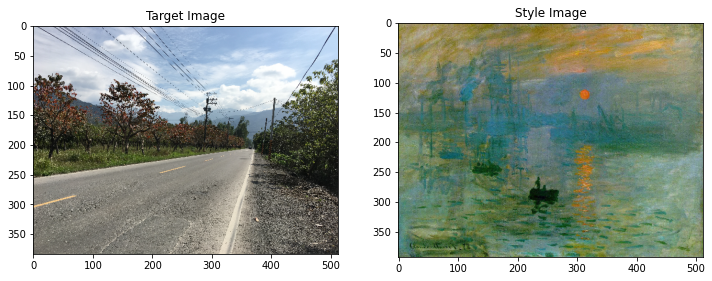

In [0]:
# 載入目標圖片及風格圖片
Target_Image = Loading_Image( Target_Image_Path )
Style_Image = Loading_Image( Style_Image_Path )

# 顯示圖片
plt.subplot(1,2,1)
Show( Target_Image, 'Target Image' )

plt.subplot(1,2,2)
Show( Style_Image, 'Style Image' )

# 實作一 : 運用 [TensorFlow Hub](https://tfhub.dev/)    

在 TensorFlow Hub 中，有許多已訓練完成的模型供大家使用，我們只需事前定義好用來顯示生成圖片的函數，並從 TensorFlow Hub 中下載模型且餵入目標及風格圖片，簡短幾行程式碼便能創作出風格轉換後的圖片。


In [0]:
def Tensor_to_Image( tensor ):
  tensor = tensor*255
  tensor = np.array( tensor, dtype=np.uint8 )
  if np.ndim(tensor) > 3 :
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray( tensor )

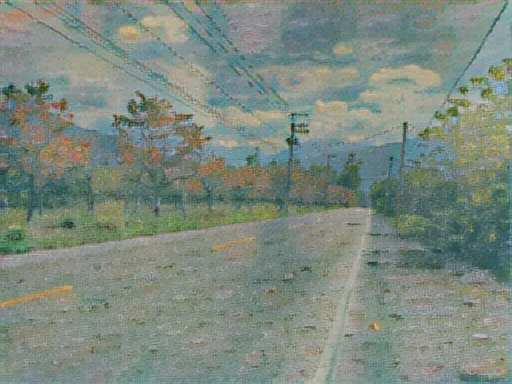

In [0]:
import tensorflow_hub as hub
hub_module = hub.load( 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2' )
Stylized_Image = hub_module( tf.constant(Target_Image), tf.constant(Style_Image) )[0]
Stylized_Image = Tensor_to_Image( Stylized_Image )
Stylized_Image

In [0]:
# 儲存路徑 = Google Drive 資料夾路徑 + 圖片名稱
Path = retval + '/TF_Hub_Stylized_' + Target_Image_Name

# 儲存 DeepDream 圖片
tf.keras.preprocessing.image.save_img( path=Path, x=Stylized_Image, file_format='png' )

# 實作二 : 手刻演算法    

接下來的範例程式碼，我們將嘗試自己搭建神經風格轉換的演算法。在建立演算法的過程中，需使用卷積神經網絡( CNN )來量化上述所提的圖片內容( Content )及風格( Style )，這裏我們將利用已預先訓練完成的 VGG19 模型來進行量化。  

建立演算法的主要過程如下 :    
&emsp;  1. 選用一個卷積神經網絡來量化目標圖片的內容及風格圖片的風格；  
&emsp;  2. 藉由量化的內容及風格定義損失函數；   
&emsp;  3. 定義梯度下降程序來最小化損失函數，並生成風格轉換圖片。  






## Step 2 : 載入 VGG19 模型

### (2.1) 載入模型   

使用 `tf.keras.applications.VGG19( )` 載入 VGG19 模型，其中，參數 `weights='imagenet'` 表示此模型的權重已預先透過 [ImageNet](http://www.image-net.org/) 訓練完成，參數 `include_top=False` 表示載入的 VGG19 模型並**不包含**最終用來預測類別的**全連接層**。

In [0]:
VGG19 = tf.keras.applications.VGG19( weights='imagenet', include_top=False )

# 檢視 VGG19 模型的結構
#VGG19.summary()

In [0]:
# VGG19 每個隱藏層的名稱
#for layer in VGG19.layers:
#  print( layer.name )

### (2.2) 選用 VGG19 隱藏層( Hidden Layer )   

在卷積神經網絡中，起初的隱藏層可用來辨識圖片的局部細節，例如：物件的輪廓、線條特徵等，而較高的隱藏層則會辨識圖片中的物件特徵，例如：樹木、電線桿、馬路等。這裏我們要從 VGG19 的隱藏層中，分別選擇用來量化內容及風格的隱藏層 ：

In [0]:
# 選取用來萃取內容特徵的隱藏層
Content_Layers = [ 'block5_conv2' ] 

# 選取用來萃取風格特徵的隱藏層
Style_Layers = [ 'block1_conv1', 'block2_conv1', 'block3_conv1', 
                 'block4_conv1', 'block5_conv1' ]

In [0]:
# 定義函數: 從 VGG19 模型中選取特定隱藏層作為生成用的模型
def VGG19_Layers( layer_names ):
  vgg = tf.keras.applications.VGG19( weights='imagenet', include_top=False )
  vgg.trainable = False  
  Layers = [ vgg.get_layer( name ).output for name in layer_names ]

  model = tf.keras.Model( [vgg.input], outputs=Layers )
  return model

卷積神經網絡中，起初隱藏層的輸出值能量化局部的圖片資訊，而較高隱藏層的輸出值量化較全面且抽象的圖片資訊，因此，在定義內容損失時，我們是利用一較高的隱藏層，來計算目標圖片與生成圖片兩者輸出值的差異，這同時代表著，我們所生成的圖片看起來會與目標圖片相似。  
在量化風格時，我們則選取多個隱藏層，目的是為盡可能萃取出風格圖片中所有的細節，此外，在萃取出的每個輸出值中，我們還會利用**格拉姆矩陣( Gram Matrix )**來計算輸出值特徵之間彼此的關聯性。因此，在定義風格損失時，我們需盡可能保存每個隱藏層輸出值的內部關聯性，意味著生成圖片與風格圖片在不同的特徵空間中，兩者有著相似的樣態。

In [0]:
Style_Extractor = VGG19_Layers( Style_Layers )
Style_Outputs = Style_Extractor( Style_Image*255 )

# 查看每個隱藏層輸出值的統計量
for name, output in zip( Style_Layers, Style_Outputs ):
  print(name)
  print( '  shape: ', output.numpy().shape )
  print( '  min: ', output.numpy().min() )
  print( '  max: ', output.numpy().max() )
  print( '  mean: ', output.numpy().mean(), '\n' )

block1_conv1
  shape:  (1, 393, 512, 64)
  min:  0.0
  max:  593.0031
  mean:  22.265812 

block2_conv1
  shape:  (1, 196, 256, 128)
  min:  0.0
  max:  3094.5288
  mean:  113.81847 

block3_conv1
  shape:  (1, 98, 128, 256)
  min:  0.0
  max:  6344.8965
  mean:  95.230736 

block4_conv1
  shape:  (1, 49, 64, 512)
  min:  0.0
  max:  14094.853
  mean:  436.99777 

block5_conv1
  shape:  (1, 24, 32, 512)
  min:  0.0
  max:  2058.0967
  mean:  26.83674 



## Step 3 : 格拉姆矩陣( Gram Matrix )   

格拉姆矩陣又稱為交互乘積矩陣( Cross- Product Matrix )，數學中的定義如下 :    
若 $A$ 為一個 $m \times n $ 的實矩陣，則格拉姆矩陣 $G$ 為  

$$ G = A^T \cdot A , $$ 其中

$$ A = 
\left[
\begin{matrix}
    | & | &  & | \\
    a_{1} & a_{2} & \cdots & a_{n} \\
    | & | &  & | \\
\end{matrix}
\right] \in R^{ m \times n } 
$$

In [0]:
# 定義格拉姆矩陣
def Gram_Matrix( input_tensor ):
  # tf.linalg 為一提供有關線性代數運算工具的模組
  result = tf.linalg.einsum( 'bijc,bijd->bcd', input_tensor, input_tensor )
  input_shape = tf.shape( input_tensor )
  num_locations = tf.cast( input_shape[1]*input_shape[2], tf.float32 )
  return result/(num_locations)

## Step 4 : 量化風格( Style )及內容( Content )

In [0]:
# 計算風格及內容特徵的隱藏層輸出值
class StyleContentModel( tf.keras.models.Model ):
  def __init__( self, style_layers, content_layers ):   # 物件初始化
    super( StyleContentModel, self ).__init__()
    self.vgg19 = VGG19_Layers( style_layers + content_layers )
    self.vgg19.trainable = False   # VGG19 模型的各隱藏層不再訓練
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len( style_layers )

  def call( self, inputs ):   # 定義類別中的方法(method)
    
    # 將圖片預處理成 VGG19 模型可處理的張量(Tensor)
    # 註: 因在載入圖片時，有對圖片進行正規化(Normalization)成 0~1 的浮點數，
    #     故這裏須先將已匯入的圖片轉成 0~255 的浮點數，再對其進行預處理，以符合 VGG19 模型的輸入規格。
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input( inputs )
    
    # 計算風格(style)及內容(content)的隱藏層輸出值
    outputs = self.vgg19( preprocessed_input )
    style_outputs, content_outputs = ( outputs[:self.num_style_layers], 
                                       outputs[self.num_style_layers:] )
    
    # 格拉姆矩陣計算風格特徵的關聯性
    style_outputs = [ Gram_Matrix(style_output)
                      for style_output in style_outputs ]
    
    # 建立有關風格及內容輸出的字典
    content_dict = { content_name:value 
                     for content_name, value 
                     in zip( self.content_layers, content_outputs ) }

    style_dict = { style_name:value
                   for style_name, value
                   in zip( self.style_layers, style_outputs ) }
    
    return { 'content':content_dict, 'style':style_dict }

In [0]:
Extractor = StyleContentModel( Style_Layers, Content_Layers )

## Step 5 : 損失函數( Loss Function )   

In [0]:
# 生成圖片的風格特徵目標值
Style_Targets = Extractor( Style_Image )['style']

# 生成圖片的內容特徵目標值
Content_Targets = Extractor( Target_Image )['content'] 

In [0]:
# 損失函數
def Style_Content_Loss( outputs, style_weight=1e-2, content_weight=1e4 ):
    style_outputs = outputs[ 'style' ]   # 風格特徵的輸出值
    content_outputs = outputs[ 'content' ]   # 內容特徵的輸出值

    # 計算風格特徵輸出值的方差( variance )作為風格損失
    style_loss = tf.add_n( [ tf.reduce_mean( (style_outputs[name]-Style_Targets[name])**2 ) 
                             for name in style_outputs.keys() ] )
    style_loss *= style_weight / len(Style_Layers)
    
    # 計算內容特徵輸出值的方差( variance )作為內容損失
    content_loss = tf.add_n( [ tf.reduce_mean( (content_outputs[name]-Content_Targets[name])**2 ) 
                               for name in content_outputs.keys() ] )
    content_loss *= content_weight / len(Content_Layers)
    
    # 總損失 = 風格損失 + 內容損失
    loss = style_loss + content_loss

    return loss

## Step 6 : 總變異損失( Total Variance Loss )   

除上述風格損失及內容損失之外，我們還需計算總變異損失，其主要目的為正規化損失，用途在於對生成圖片進行像素調整，避免產生像素顆粒化的圖片。

In [0]:
# 定義函數: 總變異損失
def Total_Variation_Loss( image ):
  x_deltas = image[:,:,1:,:] - image[:,:,:-1,:] 
  y_deltas = image[:,1:,:,:] - image[:,:-1,:,:]
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))  

# 計算目標圖片的總變異損失
Total_Variation_Loss( Target_Image )  

<tf.Tensor: shape=(), dtype=float32, numpy=101300.0>

## Step 7 : 梯度下降( Gradient Decent )    

在梯度下降的過程中，我們將對風格損失、內容損失及總變異損失三者的加權平均進行最小化。

In [0]:
def Clip_0_1( image ):
  return tf.clip_by_value( image, clip_value_min=0.0, clip_value_max=1.0 )

# 優化器
Optimizer = tf.optimizers.Adam( learning_rate=0.02, beta_1=0.99, epsilon=1e-1 )

@tf.function()
def train_step( image, style_weight=1e-2, content_weight=1e4, total_variation_weight=30 ):
  with tf.GradientTape() as tape:
    # 風格及內容特徵的每一隱藏層輸出值
    outputs = Extractor( image )
    # 損失函數計算總損失
    loss = Style_Content_Loss( outputs, style_weight, content_weight )
    loss += total_variation_weight * tf.image.total_variation( image)

  # 梯度下降
  gradients = tape.gradient( loss, image )
  Optimizer.apply_gradients( [(gradients, image)] )
  
  # 更新圖片，用新圖片進行下次訓練迭代
  image.assign( Clip_0_1(image) )

## Step 8 : 生成神經風格轉換圖片

### 參數與係數

In [0]:
Epochs = 10
Steps_per_Epoch = 100

# 各損失的權重
Style_Weight = 1e-2
Content_Weight = 1e4
Total_Variation_Weight = 30

### 執行神經風格轉換

In [0]:
Stylized_Image = tf.Variable( Target_Image )

In [0]:
def Tensor_to_Image( tensor ):
  tensor = tensor*255
  tensor = np.array( tensor, dtype=np.uint8 )
  if np.ndim(tensor) > 3 :
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray( tensor )

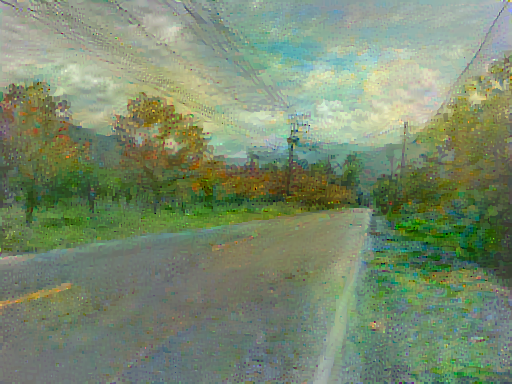

Train step: 1000
Total time: 79.9


In [0]:
import time
start = time.time()

step = 0
for n in range( Epochs ):
  for m in range( Steps_per_Epoch ):
    step += 1
    train_step( Stylized_Image, style_weight=Style_Weight, content_weight=Content_Weight, total_variation_weight=Total_Variation_Weight )
    print( '.', end='' )
  display.clear_output( wait=True )
  display.display( Tensor_to_Image(Stylized_Image) )
  print( 'Train step: {}'.format(step) )
  
end = time.time()
print( 'Total time: {:.1f}'.format(end-start) )

### 儲存神經風格轉換圖片

In [0]:
# 儲存路徑 = Google Drive 資料夾路徑 + 圖片名稱
Path = retval + '/Stylized_' + Target_Image_Name

# 儲存 DeepDream 圖片
tf.keras.preprocessing.image.save_img( path=Path, x=Tensor_to_Image(Stylized_Image), file_format='png' )

# 結語

本文透過 TensorFlow 2. 來實作神經風格轉換圖片生成，文中介紹兩種實踐的方式 ，第一種為使用 TensorFlow Hub 所提供的模型，第二種為我們從 0 到 1 地實作演算法，而兩種方式皆能生成出效果不錯的神風格轉換圖片。另外，若我們透過第二種方式實作，則可依據風格圖片及目標圖片的狀況，調整上述演算法中的 `content_weight` 係數，當 `content_weight` 比重越多時，表示生成圖片中將顯現出更明顯的目標圖片中的內容，讀者們不妨可嘗試調整權重，來生成自己喜歡的神經風格轉換圖片。      
有關本文的內容，若讀者們有發現任何的錯誤或疑問，非常歡迎您[來信( yenlinwu1112@gmail.com )]( mailto:yenlinwu1112@gmail.com )給予建議及討論，讓我們一同學習成長！

# 參考資料       

*   Neural Style Transfer [https://en.wikipedia.org/wiki/Neural_Style_Transfer](https://en.wikipedia.org/wiki/Neural_Style_Transfer)  
*   Neural Style Transfer Tutorials [https://www.tensorflow.org/tutorials/generative/style_transfer](https://www.tensorflow.org/tutorials/generative/style_transfer)